## Requirements

In [1]:
import matplotlib.pyplot as plt
import random
import statistics
import timeit
%load_ext autoreload
%autoreload 2

## Problem setting

Consider a database consisting of intervals over the positive integers, i.e., each element in the database is a half-open interval $d_i = [d_{i,s}, d_{i,e})$.  The database can be represented as $D = \{d_i | i \in [0, M)\}$, so $|D| = M$.  Clearly, for each interval $d_i$, $d_{i,e} > d{i, s} + 1$.

An intersection query is based on a query interval $q = [q_s, q_e)$ with $q_e > q_s + 1$; the query returns all intervals in $D$ that query interval intersects, i.e.,
$$
  \{ d | d \in D \wedge q_s < d_e \wedge d_s < q_e\}
$$

Rather than querying for a single interval, $N$ intervals are queried, the set of query intervals is denoted by $Q$.  The result of such a query is given by
$$
  \{(q, d) | (q, d) \in Q \times D \wedge q_s < d_e \wedge d_s < q_e\}
$$
$$
  \newcommand{\bigO}{\mathcal{O}}
$$

## Naive approach, Pythonic

As intervals in the database are unique, it can be represented as a `set` of intervals, each interval represented as a `namedtuple`.  The queries are also unique, so they can be represented by a `set` as well.

In [2]:
%pycat naive_pythonic_intersectionic_queries.py

'''
Naive and very Pythonic implementation of interval intersection queries.
'''

import itertools
import random
import typing


class Interval(typing.NamedTuple):
    '''A half-open interval [s, e)

    Attributes
    ----------
    s: int
        start of the interval, inclusive
    e: int
        end of the interval, exclusive
    '''
    s: int
    e: int

Db: typing.TypeAlias = set[Interval]
Queries: typing.TypeAlias = Db
QueryResult: typing.TypeAlias = set[tuple[Interval, Interval]]

def generate_interval(max_end: int = 1_000_000_000) -> Interval:
    '''Generate a half-open interval of at least length 1
    
    Parameters
    ----------
    max_end: int
        largest end value of the interval, default value 1_000_000_000
        
    Returns
    -------
    Interval
        Tuple (start, end) such that end - start > 1
    '''
    start = random.randint(0, max_end - 2)
    end = random.randint(start + 2, max_end)
    return Interval(s=start, e=end)


def create_db(size: int = 

The implementation is *very* Pythonic, each function is essentially a one-liner.

In [3]:
import naive_pythonic_intersectionic_queries

In [4]:
naive_pythonic_intersectionic_queries.create_db(size=10, max_end=100)

{Interval(s=1, e=17),
 Interval(s=10, e=24),
 Interval(s=22, e=88),
 Interval(s=55, e=57),
 Interval(s=59, e=93),
 Interval(s=61, e=80),
 Interval(s=63, e=88),
 Interval(s=82, e=92),
 Interval(s=92, e=98),
 Interval(s=93, e=95)}

For benchmarking, these parameters are used.

In [5]:
sizes = [2**i for i in range(7, 14)]
nr_repeats = 5

In [6]:
random.seed(1234)
naive_pythonic_times = [
    timeit.repeat(
        stmt='naive_pythonic_intersectionic_queries.execute_queries(queries, db)',
        setup=f'queries, db = naive_pythonic_intersectionic_queries.create_queries({size}), naive_pythonic_intersectionic_queries.create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

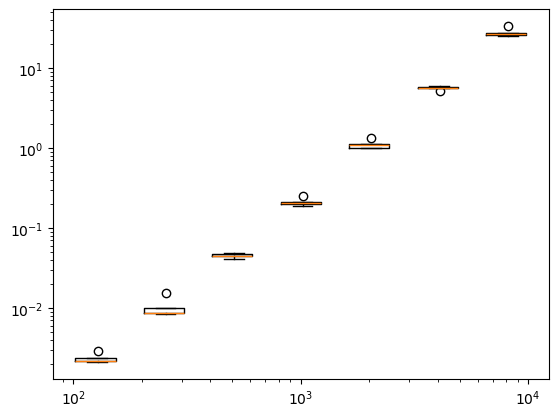

In [7]:
plt.boxplot(naive_pythonic_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.xscale('log')
plt.yscale('log');

The time complexity of this algorithm is $\bigO(N^2)$ for $|D| = |Q| = N$, as expected.

## Still naive, not Pythonic

Sometimes performance and elegance are not a good match.  The following implementation is less Pythonic, but a bit faster.  It is still naive though, so the time complexity will not change.

In [8]:
%pycat naive_intersectionic_queries.py

'''
Naive but not Pythonic implementation of interval intersection queries.
'''

import collections
import itertools
import random
import typing


Interval: typing.TypeAlias = tuple[int, int]
Db: typing.TypeAlias = list[Interval]
Queries: typing.TypeAlias = Db
QueryResult: typing.TypeAlias = list[tuple[Interval, Interval]]

def generate_interval(max_end: int = 1_000_000_000) -> Interval:
    '''Generate a half-open interval of at least length 1
    
    Parameters
    ----------
    max_end: int
        largest end value of the interval, default value 1_000_000_000
        
    Returns
    -------
    Interval
        Tuple (start, end) such that end - start > 1
    '''
    start = random.randint(0, max_end - 2)
    end = random.randint(start + 2, max_end)
    return start, end


def create_db(size: int = 1_000, max_end: int = 1_000_000) -> Db:
    '''Generate a database of intervals
    
    Parameters
    ----------
    size: int
        number of intervals in the database, default v

As you can see, not much changed, rather than a `namedtuple` to represent an interval, an ordinary `tuple` is used, while a `list` is replacing the `set` to represent the database and queries.

In [9]:
import naive_intersectionic_queries

In [10]:
random.seed(1234)
naive_times = [
    timeit.repeat(
        stmt='naive_intersectionic_queries.execute_queries(queries, db)',
        setup=f'queries, db = naive_intersectionic_queries.create_queries({size}), naive_intersectionic_queries.create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

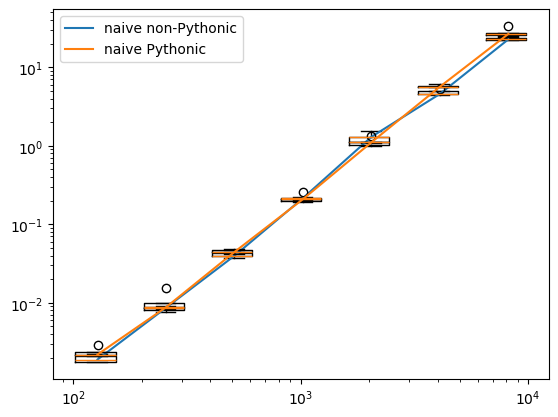

In [11]:
plt.boxplot(naive_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, naive_times)), label='naive non-Pythonic')
plt.boxplot(naive_pythonic_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, naive_pythonic_times)), label='naive Pythonic')
plt.legend()
plt.xscale('log')
plt.yscale('log');

As expected, the cime complexity is still $\bigO(N^2)$, but this implementation is 1.5 times faster.

In [12]:
statistics.mean(naive_times[-1])/statistics.mean(naive_pythonic_times[-1])

0.8240638442386783

## Intersection trees

A better approach for interval queries is to use a clever datastructure to represent the database.  The intervals are stored as nodes of a binary tree, so each node has the start and end value of an interval.  Additionally, each node also stores the maximum end of all the intervals stored as its children.  The first interval stored in the database is the root of the tree.  When a new interval is inserted, it will be inserted as or by the left child of a node if its start value is less than that node's, as or by the child otherwise.  Upon insertion, the maximum end value is updated as well.

This approach allows to eliminate large parts of the tree from the search process.

In [13]:
%pycat intersection_tree.py

'''
Implementation of an intersection tree approach for efficiently finding
intersections among a set of query intervals and a database intervals.

This module provides:
- Node: A tree node representing an interval with efficient intersection search
- Utility functions for generating intervals, creating databases, and executing queries

Note: The tree structure is a binary search tree ordered by interval start points.
In worst case scenarios (e.g., with sorted input), the tree may become unbalanced
and degrade to O(n) performance instead of the optimal O(log n).

Example usage:
    >>> from intersection_tree import create_db, create_queries, execute_queries
    >>> db = create_db(size=100)
    >>> queries = create_queries(size=10)
    >>> results = execute_queries(queries, db)
'''

import random
import typing


Interval: typing.TypeAlias = tuple[int, int]
Queries: typing.TypeAlias = list[Interval]
QueryResult: typing.TypeAlias = list[tuple[Interval, Interval]]

class Node:
    '''Class

In [14]:
import intersection_tree

A small test to see how it works.

In [15]:
db = intersection_tree.create_db(size=10, max_end=500)

In [16]:
print(db)

[292, 496] (max_end=496)
  [1, 141] (max_end=420)
    [48, 236] (max_end=420)
      [174, 243] (max_end=420)
        [154, 420] (max_end=420)
        [204, 397] (max_end=397)
  [351, 415] (max_end=476)
    [416, 458] (max_end=476)
      [395, 476] (max_end=476)
      [465, 473] (max_end=473)



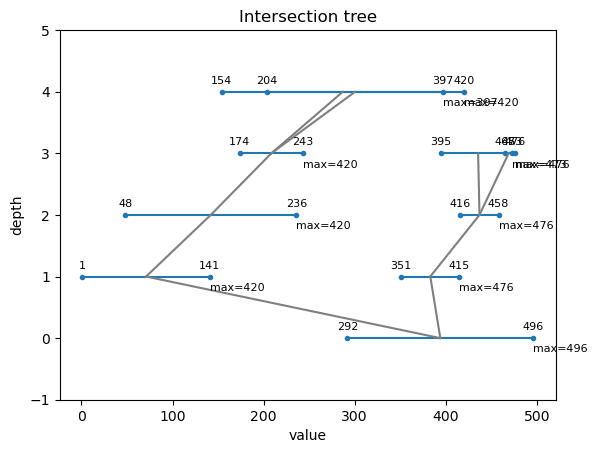

In [17]:
intersection_tree.plot_intersection_tree(db)

In [18]:
results = []
db.search((25, 30), results)

In [19]:
results

[(1, 141)]

You can check the performance of this implementation and compare it to the previous ones.

In [20]:
sizes = [2**i for i in range(7, 14)]
nr_repeats = 5

In [21]:
random.seed(1234)
intersection_tree_times = [
    timeit.repeat(
        stmt='intersection_tree.execute_queries(queries, db)',
        setup=f'queries, db = intersection_tree.create_queries({size}), intersection_tree.create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

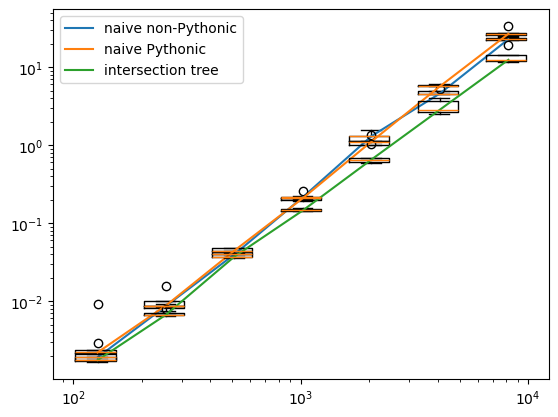

In [22]:
plt.boxplot(naive_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, naive_times)), label='naive non-Pythonic')
plt.boxplot(naive_pythonic_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, naive_pythonic_times)), label='naive Pythonic')
plt.boxplot(intersection_tree_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, intersection_tree_times)), label='intersection tree')
plt.legend()
plt.xscale('log')
plt.yscale('log');

In [23]:
statistics.mean(intersection_tree_times[-1])/statistics.mean(naive_times[-1])

0.6092673672517709


It is clear that the intersection tree implementation is more efficient than the naive approaches.  The expected complexity is $\mathcal{O}(N \log N)$ where both the number of query intervals and the number of intervals in the database is $N$.

It is clear that the intersection tree implementation is more efficient than the naive approaches.  The expected time complexity is $\bigO(N \log N)$ for $|Q| = |D| = N$.  Likely, the actual time complexity will be worse since the vinary tree is unlikely to be balanced.

## Array-based intersection trees

The array-based implementation offers an alternative approach to the traditional node-based intersection tree. Instead of using individual node objects, this implementation stores tree data in arrays, which can provide better cache locality and memory efficiency for large datasets.

Each node is represented by an index into the arrays, and the tree structure is maintained through indices rather than object references.

In [24]:
%pycat array_intersection_tree.py

'''
Array-based implementation of an intersection tree for efficiently finding
intersections among a set of query intervals and a database intervals.

This module provides an alternative implementation using arrays instead of
traditional tree node objects, potentially offering better cache locality
and performance for large datasets.

The Tree object contains arrays start, end, max_end, left, and right.
A node is represented by an index into these arrays, and left/right
refer to the indices of respective child nodes (-1 indicates None).

Example usage:
    >>> from array_intersection_tree import ArrayTree, create_db, create_queries, execute_queries
    >>> db = create_db(size=100)
    >>> queries = create_queries(size=10)
    >>> results = execute_queries(queries, db)
'''

import random
import typing


Interval: typing.TypeAlias = tuple[int, int]
Queries: typing.TypeAlias = list[Interval]
QueryResult: typing.TypeAlias = list[tuple[Interval, Interval]]


class ArrayTree:
    '''Array-ba

In [25]:
import array_intersection_tree

In [26]:
# Create a small database for demonstration
array_db = array_intersection_tree.create_db(size=10, max_end=500)
print(f"Created array-based tree with {array_db.size()} intervals")
print("\nTree structure:")
print(array_db)

Created array-based tree with 10 intervals

Tree structure:
[292, 496] (max_end=496) @0
  [1, 141] (max_end=420) @2
    [48, 236] (max_end=420) @4
      [174, 243] (max_end=420) @5
        [154, 420] (max_end=420) @8
        [204, 397] (max_end=397) @9
  [351, 415] (max_end=476) @1
    [416, 458] (max_end=476) @3
      [395, 476] (max_end=476) @7
      [465, 473] (max_end=473) @6



In [27]:
# Demonstrate search functionality
query_interval = (25, 30)
results = []
array_db.search(query_interval, results)
print(f"Query interval {query_interval} intersects with:")
for result in results:
    print(f"  {result}")
print(f"\nTotal intersections found: {len(results)}")

Query interval (25, 30) intersects with:
  (1, 141)

Total intersections found: 1


In [28]:
# Performance benchmarking for array-based implementation
sizes = [2**i for i in range(7, 14)]
nr_repeats = 5

In [29]:
random.seed(1234)
array_intersection_tree_times = [
    timeit.repeat(
        stmt='array_intersection_tree.execute_queries(queries, db)',
        setup=f'queries, db = array_intersection_tree.create_queries({size}), array_intersection_tree.create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

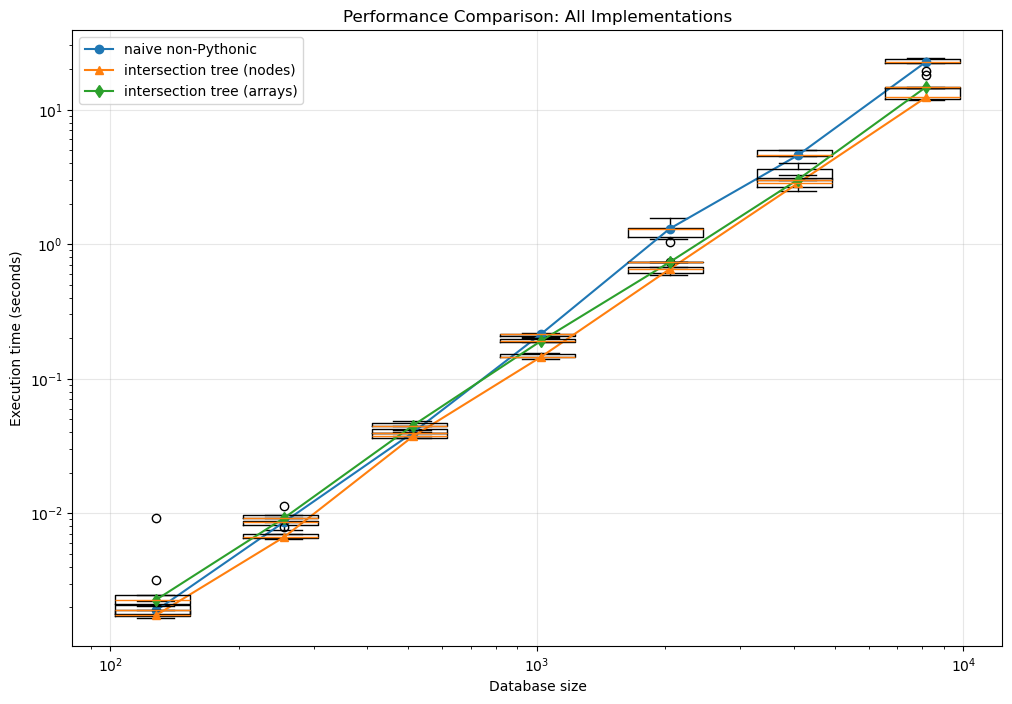

In [30]:
# Plot comparison of all implementations including array-based
plt.figure(figsize=(12, 8))
plt.boxplot(naive_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, naive_times)), label='naive non-Pythonic', marker='o')
plt.boxplot(intersection_tree_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, intersection_tree_times)), label='intersection tree (nodes)', marker='^')
plt.boxplot(array_intersection_tree_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.plot(sizes, list(map(statistics.median, array_intersection_tree_times)), label='intersection tree (arrays)', marker='d')
plt.legend()
plt.xlabel('Database size')
plt.ylabel('Execution time (seconds)')
plt.title('Performance Comparison: All Implementations')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# Compare array-based vs node-based intersection tree performance
array_vs_node_ratio = statistics.mean(array_intersection_tree_times[-1])/statistics.mean(intersection_tree_times[-1])
print(f"Array-based vs Node-based tree performance ratio: {array_vs_node_ratio:.3f}")
print(f"Array-based vs Naive performance ratio: {statistics.mean(array_intersection_tree_times[-1])/statistics.mean(naive_times[-1]):.3f}")

Array-based vs Node-based tree performance ratio: 1.098
Array-based vs Naive performance ratio: 0.669


### Analysis

The array-based implementation provides similar algorithmic performance to the node-based intersection tree with $\mathcal{O}(N \log N)$ expected time complexity. The main differences are:

- **Memory layout**: Arrays provide better cache locality compared to scattered node objects
- **Memory overhead**: Reduced per-node memory overhead (no object headers)
- **Capacity management**: Uses dynamic array resizing instead of individual node allocation

The performance difference depends on factors such as dataset size, query patterns, and system architecture.

## Testing

Since the naive appreach is pretty straightforward, and the intersection tree is a bit more sophisticated, it might be wise to compare the results by way of test.

In [32]:
import intersection_tree
import naive_intersectionic_queries
import array_intersection_tree

random.seed(1234)
max_end = 1_000_000
nr_intervals = 1_000
nr_queries = 1_000
db_intervals = [
    intersection_tree.generate_interval(max_end=max_end) for _ in range(nr_intervals)
]
queries = intersection_tree.create_queries(size=nr_queries, max_end=max_end)

# Test node-based intersection tree
db = intersection_tree.populate_db(None, db_intervals)
db_results = intersection_tree.execute_queries(queries, db)

# Test naive implementation
naive_db = db_intervals
naive_db_result = naive_intersectionic_queries.execute_queries(queries, naive_db)

# Test array-based intersection tree
array_db = array_intersection_tree.populate_db(None, db_intervals)
array_db_results = array_intersection_tree.execute_queries(queries, array_db)

# Verify all implementations produce identical results
assert len(db_results) == len(naive_db_result) == len(array_db_results)
assert set(db_results) == set(naive_db_result) == set(array_db_results)

All algorithms yield identical results.